In [2]:
from musegan import WGAN_GP, Wasserstein, Monitor, binarise_output, notes_to_midi

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import types
from music21 import midi
from music21 import note, stream, duration, tempo
from functools import partial
import tensorflow as tf
from keras.optimizers import Adam

In [4]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4
z_dim = 32
epoch = 0

In [5]:
file = os.path.join('jsb', 'Jsb16thSeparated.npz')

In [6]:
with np.load(file, allow_pickle=True, encoding='bytes') as f:
    data = f['train']

    data_ints = []

for x in data:
    counter = 0
    cont = True
    while cont:
        if not np.any(np.isnan(x[counter:(counter+4)])):
            cont = False
        else:
            counter += 4

    if n_bars * n_steps_per_bar < x.shape[0]:
        data_ints.append(x[counter:(counter + (n_bars * n_steps_per_bar)),:])


data_ints = np.array(data_ints)

n_songs = data_ints.shape[0]
n_tracks = data_ints.shape[2]

data_ints = data_ints.reshape([n_songs, n_bars, n_steps_per_bar, n_tracks])

max_note = 83

where_are_NaNs = np.isnan(data_ints)
data_ints[where_are_NaNs] = max_note + 1
max_note = max_note + 1

data_ints = data_ints.astype(int)

num_classes = max_note + 1

    
data_binary = np.eye(num_classes)[data_ints]
data_binary[data_binary==0] = -1
data_binary = np.delete(data_binary, max_note,-1)

data_binary = data_binary.transpose([0,1,2, 4,3])

In [7]:
data_binary.shape

(229, 2, 16, 84, 4)

In [8]:
generator_opti = Adam(learning_rate=0.001)
critic_opti = Adam(learning_rate=0.001)

In [9]:
gan = WGAN_GP(data_binary.shape[1:], grad_weight = 50, z_dim=z_dim,
batch_size = BATCH_SIZE,  n_tracks = n_tracks, n_bars= n_bars,
 n_steps_per_bar = n_steps_per_bar, n_pitches = n_pitches)

In [10]:
gan.compile(d_optimizer=critic_opti, g_optimizer=generator_opti,d_loss_fn=Wasserstein, g_loss_fn = Wasserstein)

In [14]:
epochs = 6000
cbk = Monitor(z_dim,n_bars, n_steps_per_bar, n_tracks, 'images')

In [11]:
history = gan.fit(data_binary,batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Epoch 1/6000
4/4 [==============================] - 69s 2s/step - d_loss: -97.0084 - r: -129.5549 - f: 7.5182 - gp: 0.5006 - g_loss: -6.3742
Epoch 2/6000
4/4 [==============================] - 4s 983ms/step - d_loss: -64.9403 - r: -135.6969 - f: 46.4946 - gp: 0.4852 - g_loss: -48.9010
Epoch 3/6000
4/4 [==============================] - 4s 980ms/step - d_loss: -30.4473 - r: -101.1742 - f: 62.3722 - gp: 0.1671 - g_loss: -70.0628
Epoch 4/6000
4/4 [==============================] - 4s 987ms/step - d_loss: -16.5518 - r: -64.9677 - f: 47.1009 - gp: 0.0263 - g_loss: -68.5521
Epoch 5/6000
4/4 [==============================] - 4s 986ms/step - d_loss: -14.7129 - r: -85.4594 - f: 69.3980 - gp: 0.0270 - g_loss: -79.1530
Epoch 6/6000
4/4 [==============================] - 4s 988ms/step - d_loss: -15.9339 - r: -109.3788 - f: 91.6591 - gp: 0.0357 - g_loss: -94.9600
Epoch 7/6000
4/4 [==============================] - 4s 984ms/step - d_loss: -19.3080 - r: -101.1719 - f: 79.7929 - gp: 0.0414 - g_loss: 

In [12]:
len(history.history['d_loss'])

6000

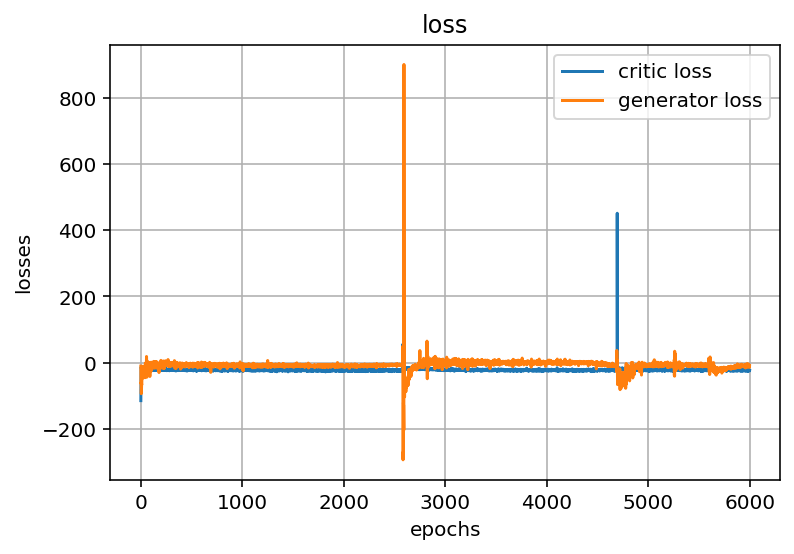

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
ep = np.arange(1,epochs+1)
plt.plot(ep, history.history['d_loss'])
plt.plot(ep, history.history['g_loss'])
plt.legend(['critic loss','generator loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('losses')
plt.grid()

In [120]:
gan.save()

In [11]:
gan.load('wgan/wgan/generator.h5','wgan/wgan/critic.h5')

In [12]:
from keras.utils.vis_utils import plot_model

In [15]:
gan.generator.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 melody_input (InputLayer)      [(None, 4, 32)]      0           []                               
                                                                                                  
 chords_input (InputLayer)      [(None, 32)]         0           []                               
                                                                                                  
 lambda (Lambda)                (None, 32)           0           ['melody_input[0][0]']           
                                                                                                  
 lambda_1 (Lambda)              (None, 32)           0           ['melody_input[0][0]']           
                                                                                            

                                                                  'lambda_11[0][0]']              
                                                                                                  
 total_input_bar_1_track_0 (Con  (None, 128)         0           ['chords_input_bar_1[0][0]',     
 catenate)                                                        'style_input[0][0]',            
                                                                  'lambda_12[0][0]',              
                                                                  'lambda_13[0][0]']              
                                                                                                  
 total_input_bar_1_track_1 (Con  (None, 128)         0           ['chords_input_bar_1[0][0]',     
 catenate)                                                        'style_input[0][0]',            
                                                                  'lambda_14[0][0]',              
          

In [36]:
for i in range(5):
    chords_noise = tf.random.normal( shape=(1,z_dim))
    style_noise = tf.random.normal( shape=(1,z_dim))
    melody_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    groove_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    generated_image = gan.generator.predict([chords_noise, style_noise,melody_noise, groove_noise])

    notes_to_midi(n_tracks,n_bars*2, n_steps_per_bar, epoch, tf.concat([generated_image,generated_image],axis=1), f'sample_{i}')

1/1 [==============================] - 0s 34ms/step


In [12]:
for i in range(50):
    chords_noise = tf.random.normal( shape=(1,z_dim))
    style_noise = tf.random.normal( shape=(1,z_dim))
    melody_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    groove_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    generated_image_1 = gan.generator.predict([chords_noise, style_noise,melody_noise, groove_noise])
    melody_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    groove_noise = tf.random.normal( shape=(1,n_tracks, z_dim))
    generated_image_2 = gan.generator.predict([chords_noise, style_noise,melody_noise, groove_noise])

    notes_to_midi(n_tracks,n_bars*2, n_steps_per_bar, epoch, tf.concat([generated_image_1,generated_image_2],axis=1), f'sample_{i}')

1/1 [==============================] - 0s 29ms/step


In [21]:
gan.critic.save_weights('wgan/critic_weights.h5')
gan.generator.save_weights('wgan/generator_weights.h5')